In [10]:
# 载入 Python 依赖库
import os
# mac 系统上 PyTorch 和 Matplotlib 在 Jupyter 中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "png"
# %config InlineBackend.figure_format = "svg"

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
print(f"torch.__version__={torch.__version__}")

from torchkeras.kerasmodel import KerasModel
from torchkeras.utils.plot_metrics import plot_metrics
from torchkeras.metrics import Accuracy

torch.__version__=1.9.1


In [5]:
# 数据读取、查看
df_train_raw = pd.read_csv("./data/titanic/train.csv")
df_test_raw = pd.read_csv("./data/titanic/test.csv")
print(df_train_raw.head(10))
print(df_train_raw.info())

   PassengerId  Survived  Pclass  \
0          493         0       1   
1           53         1       1   
2          388         1       2   
3          192         0       2   
4          687         0       3   
5           16         1       2   
6          228         0       3   
7          884         0       2   
8          168         0       3   
9          752         1       3   

                                              Name     Sex   Age  SibSp  \
0                       Molson, Mr. Harry Markland    male  55.0      0   
1         Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   
2                                 Buss, Miss. Kate  female  36.0      0   
3                            Carbines, Mr. William    male  19.0      0   
4                         Panula, Mr. Jaako Arnold    male  14.0      4   
5                 Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
6                  Lovell, Mr. John Hall ("Henry")    male  20.5      0   
7  

In [6]:
# 数据预处理
def preprocessing(data):
    data_result = pd.DataFrame()

    # Pclass one-hot 编码
    Pclass = pd.get_dummies(data["Pclass"])
    Pclass.columns = ["Pclass_" + str(x) for x in Pclass.columns]
    data_result = pd.concat([data_result, Pclass], axis = 1)

    # Sex  bool 编码
    Sex = pd.get_dummies(data["Sex"])
    data_result = pd.concat([data_result, Sex], axis = 1)
    
    # Age 添加是否缺失作为辅助特征
    data_result["Age"] = data["Age"].fillna(0)
    data_result["Age_null"] = pd.isna(data["Age"]).astype("int32")
    
    # SibSp, Parch, Fare
    data_result["SibSp"] = data["SibSp"]
    data_result["Parch"] = data["Parch"]
    data_result["Fare"] = data["Fare"]
    
    # Cabin 添加所在船舱是否缺失作为辅助特征
    data_result["Cabin"] = pd.isna(data["Cabin"]).astype("int32")
    
    # Embarked one-hot 编码，四维度 S,C,Q,nan
    Embarked = pd.get_dummies(data["Embarked"], dummy_na = True)
    Embarked.columns = ["Embarked_" + str(x) for x in Embarked.columns]
    data_result = pd.concat([data_result, Embarked], axis = 1)
    
    return data_result

x_train = preprocessing(df_train_raw).values
y_train = df_train_raw[["Survived"]].values

x_test = preprocessing(df_test_raw).values
y_test = df_test_raw[["Survived"]].values

print(f"x_train.shape={x_train.shape}")
print(f"x_test.shape={x_test.shape}")

print(f"y_train.shape={y_train.shape}")
print(f"y_test.shape={y_test.shape}")

x_train.shape=(712, 15)
x_test.shape=(179, 15)
y_train.shape=(712, 1)
y_test.shape=(179, 1)


In [7]:
# 使用 DataLoader 和 TensorDataset 封装成可以迭代的数据管道
dl_train = DataLoader(
    TensorDataset(
        torch.tensor(x_train).float(),
        torch.tensor(y_train).float(),
    ),
    shuffle = True,
    batch_size = 8,
)
dl_validate = DataLoader(
    TensorDataset(
        torch.tensor(x_test).float(),
        torch.tensor(y_test).float(),
    ),
    shuffle = False,
    batch_size = 8,
)

# 数据管道测试
for features, labels in dl_train:
    print(features, labels)
    break

tensor([[  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  27.0000,   0.0000,
           0.0000,   2.0000, 211.5000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  39.0000,   0.0000,
           0.0000,   0.0000,  24.1500,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  33.0000,   0.0000,
           0.0000,   0.0000,   7.8958,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  52.0000,   0.0000,
           1.0000,   0.0000,  78.2667,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  36.0000,   0.0000,
           0.0000,   1.0000, 512.3292,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000,   

In [8]:
# 定义模型
def create_net():
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(15, 20))
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear2", nn.Linear(20, 15))
    net.add_module("relu2", nn.ReLU())
    net.add_module("linear3", nn.Linear(15, 1))
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
)


In [11]:
# 训练模型
kerasmodel = KerasModel(
    net = net,
    loss_fn = nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.01),
    metrics_dict = {"acc": Accuracy()},
)
history_df = kerasmodel.fit(
    train_data = dl_train,
    validate_data = dl_validate,
    epochs = 20,
    ckpt_path = "./torchcheckpoint/checkpoint.pt",
    patience = 5,
    monitor = "val_acc",
    mode = "max",
)

/Users/wangzf/.pyenv/versions/3.7.10/envs/pytorch/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Accuracy). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
 45%|████▍     | 40/89 [00:00<00:00, 393.69it/s, train_acc=0.625, train_loss=0.519]


================================================================================2022-08-30 22:29:04
Epoch 1 / 20



100%|██████████| 23/23 [00:00<00:00, 675.79it/s, val_acc=0.737, val_loss=0.54]
<<<<<< reach best val_acc : 0.7374301552772522 >>>>>>
 47%|████▋     | 42/89 [00:00<00:00, 414.54it/s, train_acc=0.875, train_loss=0.385]


================================================================================2022-08-30 22:29:04
Epoch 2 / 20



  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.875, val_loss=0.378]


================================================================================2022-08-30 22:29:04
Epoch 3 / 20



100%|██████████| 23/23 [00:00<00:00, 657.84it/s, val_acc=0.754, val_loss=0.516]
<<<<<< reach best val_acc : 0.7541899681091309 >>>>>>
  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.75, val_loss=0.603] 


================================================================================2022-08-30 22:29:05
Epoch 4 / 20



100%|██████████| 23/23 [00:00<00:00, 661.37it/s, val_acc=0.777, val_loss=0.422]
<<<<<< reach best val_acc : 0.7765362858772278 >>>>>>
  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.75, val_loss=0.49]  


================================================================================2022-08-30 22:29:05
Epoch 5 / 20



100%|██████████| 23/23 [00:00<00:00, 636.56it/s, val_acc=0.821, val_loss=0.434]
<<<<<< reach best val_acc : 0.8212290406227112 >>>>>>
 45%|████▍     | 40/89 [00:00<00:00, 394.74it/s, train_acc=0.875, train_loss=0.322]


================================================================================2022-08-30 22:29:05
Epoch 6 / 20



  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.625, val_loss=0.69] 


================================================================================2022-08-30 22:29:05
Epoch 7 / 20



  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.875, val_loss=0.441]


================================================================================2022-08-30 22:29:06
Epoch 8 / 20



  0%|          | 0/23 [00:00<?, ?it/s, val_acc=0.75, val_loss=0.691] 


================================================================================2022-08-30 22:29:06
Epoch 9 / 20



  0%|          | 0/23 [00:00<?, ?it/s, val_acc=1, val_loss=0.179]    


================================================================================2022-08-30 22:29:06
Epoch 10 / 20



100%|██████████| 23/23 [00:00<00:00, 691.36it/s, val_acc=0.821, val_loss=0.413]
<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>


In [12]:
# ---------------------------------------
# 评估模型
# ---------------------------------------
history_df

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.635530,0.681180,0.540052,0.737430,1
1,0.536681,0.747191,0.539105,0.715084,2
2,0.512580,0.778090,0.515708,0.754190,3
3,0.511247,0.786517,0.421547,0.776536,4
4,0.455210,0.808989,0.433660,0.821229,5
5,0.457026,0.801966,0.462014,0.782123,6
6,0.470381,0.801966,0.530170,0.754190,7
7,0.467406,0.792135,0.425298,0.810056,8
8,0.461230,0.801966,0.490840,0.798883,9
9,0.442517,0.821629,0.412648,0.821229,10


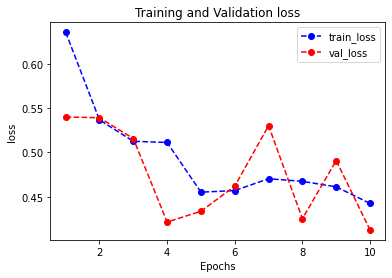

In [14]:
plot_metrics(history_df, "loss")

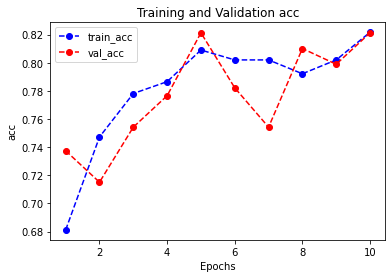

In [15]:
plot_metrics(history_df, "acc")

In [19]:
# 使用模型
## 预测概率
y_pred_probs = torch.sigmoid(net(torch.tensor(x_test[0:10]).float())).data
y_pred_probs

tensor([[0.2334],
        [0.7151],
        [0.3749],
        [0.8815],
        [0.5871],
        [0.8797],
        [0.1440],
        [0.8141],
        [0.5037],
        [0.2207]])

In [20]:
## 预测类别
y_pred = torch.where(
    y_pred_probs > 0.5, 
    torch.ones_like(y_pred_probs),
    torch.zeros_like(y_pred_probs),
)
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [18]:
# 保存模型
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [21]:
# 保存模型参数
torch.save(net.state_dict(), "./torchmodels/net_parameter_titanic.pt")
net_clone = create_net()
net_clone.load_state_dict(torch.load("./torchmodels/net_parameter_titanic.pt"))
torch.sigmoid(net_clone.forward(torch.tensor(x_test[0:10]).float())).data

tensor([[0.2334],
        [0.7151],
        [0.3749],
        [0.8815],
        [0.5871],
        [0.8797],
        [0.1440],
        [0.8141],
        [0.5037],
        [0.2207]])

In [22]:
# 保存完整模型
torch.save(net, "./torchmodels/net_model_titanic.pt")
net_loaded = torch.load("./torchmodels/net_model_titanic.pt")
torch.sigmoid(net_loaded(torch.tensor(x_test[0:10]).float())).data

tensor([[0.2334],
        [0.7151],
        [0.3749],
        [0.8815],
        [0.5871],
        [0.8797],
        [0.1440],
        [0.8141],
        [0.5037],
        [0.2207]])